In [1]:
import gfc
from gfc import *
import numpy as np
import scipy as sp
from scipy.stats import chi2
import copy as cp
from extreme_deconvolution import extreme_deconvolution as xd
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib import gridspec as gs
from matplotlib.patches import Ellipse
import matplotlib as mpl
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import Angle
from pygaia.astrometry.vectorastrometry import phaseSpaceToAstrometry, astrometryToPhaseSpace, sphericalToCartesian, normalTriad
from pygaia.astrometry.coordinates import CoordinateTransformation, Transformations
from pygaia.astrometry import constants

galtoicrs = CoordinateTransformation(Transformations.GAL2ICRS)
icrstogal = CoordinateTransformation(Transformations.ICRS2GAL)

rc('font',**{'family':'serif', 'serif':['Times']})
rc('text', usetex=True)

root_folder = "/disks/strw9/vanweenen/mrp1/results/simulation"

In [5]:
K = 2 #nr of components
N = 1000 #nr of stars
wmin = 0.5 ; wmax=20 ; wstep=1.
#wmin = 0.5 ; wmax=5 ; wstep=.25
Kmin=1 ; Kmax=10 ; Kstep=1

wrange = np.arange(wmin, wmax + wstep, wstep)**2.
Krange = range(Kmin, Kmax + Kstep, Kstep) #Krange from Kmin to Kmax

def simulation(meanstep, sigma, p):    
    def simulate_amps(k):
        #a = np.empty([k])
        #rest = 1
        #for i in range(k-1):
        #    a[i] = (1./k)/(i+2)**p
        #    rest -= a[i]
        #a[k-1] = rest
        #return a
        if k > 1:
            f = np.array([(i+1)**p for i in range(2)])
            a = f/np.sum(f)
            if k > 2:
                for i in range(k-2):
                    a = np.append(a,1/(100-(k-2)))
                a /= np.sum(a)
        else:
            a = [1]
        return a

    def simulate_means(k):
        m = np.empty([k, 3])
        for i in range(k):
            m[i,:] = [meanstep*i, meanstep*i, meanstep*i]
        return m

    def simulate_covs(k):
        c = np.zeros((k,3,3))
        for i in range(k):
            c[i,0,0] = (sigma)**2
            c[i,1,1] = (sigma)**2
            c[i,2,2] = (sigma)**2
        return c

    def initial_values():
        inita = []
        initm = []
        initc = []

        for k in range(Kmin, Kmax+1):
            inita.append(simulate_amps(k))
            initm.append(simulate_means(k))
            initc.append(simulate_covs(k))
        return inita, initm, initc

    # Simulate a collection of stars distributed at constant space density around the sun, 
    # with distances between 1 and 500 pc. Use Galactic coordinates. Each star is assigned
    # a 3D space velocity drawn from a superposition of several 3D normal distributions in 
    # velocity space.
    rmin = 1. #pc
    rmax = 500. #pc
    
    r = np.random.uniform(rmin**3, rmax**3, N)**(1./3.) #pc
    theta = np.arccos(np.random.uniform(-1, 1, N))-np.pi/2
    phi = np.random.uniform(0, 2*np.pi, N)

    x_gal,y_gal,z_gal = sphericalToCartesian(r, phi, theta)

    # Define the space velocities (u,v,w), again in galactic coordinates
    inita, initm, initc = initial_values()
    print(inita[K-1], initm[K-1], initc[K-1])

    # Simulate velocity for every star
    component = np.random.choice(K, N, p=inita[K-1]) #choose component
    uvw_gal = np.empty([N,3])
    for i in range(N):
        uvw_gal[i] = np.random.multivariate_normal(initm[K-1][component[i],:], initc[K-1][component[i],:,:])

    # Transform the simulated positions and velocities into astrometric observables and radial velocity in ICRS
    print("Transformation to astrometric observables..")
    x_icrs, y_icrs, z_icrs = galtoicrs.transformCartesianCoordinates(x_gal, y_gal, z_gal)
    u_icrs, v_icrs, w_icrs = galtoicrs.transformCartesianCoordinates(uvw_gal[:,0], uvw_gal[:,1], uvw_gal[:,2])
    alpha, delta, parallax, mura, mudec, vrad = phaseSpaceToAstrometry(x_icrs, y_icrs, z_icrs, u_icrs, v_icrs, w_icrs) #rad, rad, mas, mas/yr, mas/yr, km/s
    astr_true = np.column_stack((alpha, delta, parallax, mura, mudec, vrad))

    print("Simulate measured values..")
    #Simulate measured values using measurement errors
    measurement_error = np.array([0.,0.,0.3,1.,1.,0])
    measurement_covar = np.diag(measurement_error**2) #measurement errors
    astr_measured = np.empty([N,6])
    for i in range(N):
        astr_measured[i] = np.random.multivariate_normal(astr_true[i,:], measurement_covar, 1)
    errors_measured = np.tile(measurement_error, (N,1))
    corr_measured = np.tile(np.tile([0.],15), (N,1))

    arr_astr = np.column_stack((astr_measured, errors_measured, corr_measured))
    labels = ('ra', 'dec', 'parallax', 'pmra', 'pmdec', 'vrad', 'ra_error', 'dec_error', 'parallax_error', 'pmra_error', 'pmdec_error', 'vrad_error', 'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 'ra_vrad_corr', 'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 'dec_vrad_corr', 'parallax_pmra_corr', 'parallax_pmdec_corr', 'parallax_vrad_corr', 'pmra_pmdec_corr', 'pmra_vrad_corr', 'pmdec_vrad_corr')
    t_astr=Table(arr_astr, names=labels)

    print("Projection..")
    # Calculate the projection matrix analogous to equation (1) in Bovy et al 2009 
    # (https://ui.adsabs.harvard.edu/#abs/2009ApJ...700.1794B/abstract). Note the different ordering of the
    # velocity components.
    t_astr_vrad0 = cp.copy(t_astr)
    for i in ['ra', 'dec']:
        gfc.add_rad(t_astr_vrad0, i, u.rad, u.rad)
        gfc.add_rad(t_astr, i, u.rad, u.rad)

    # Do not give radial velocity data to transformation
    matrix.transformation(t_astr_vrad0)#, vrad_col = 'vrad')
    warr_vr0 = gfc.XD_arr(t_astr_vrad0, "w") #icrs
    wcovar_vr0 = gfc.XD_arr(t_astr_vrad0, "S") ; wcovar_vr0[:,2,2] = 1e15
    varr_vr0 = gfc.XD_arr(t_astr_vrad0, "UVW")
    proj_vr0 = gfc.XD_arr(t_astr_vrad0, "R")

    # Give radial velocity data to transformation
    matrix.transformation(t_astr, vrad_col = 'vrad')
    warr = gfc.XD_arr(t_astr, "w") #icrs
    wcovar = gfc.XD_arr(t_astr, "S")
    varr = gfc.XD_arr(t_astr, "UVW")
    proj = gfc.XD_arr(t_astr, "R")
    
    # Perform XD
    print("Perform XD..")
    # The input to XD are the values of v_alpha*, v_delta, vrad. The other input required is the projection matrix.
    # The values of v_alpha*, v_delta, vrad are obtained from (alpha, delta, parallax, mura,  mudec, vrad).
    logL, AIC, MDL, a_test, m_test, c_test, bestK, bestw = gfc.perform_XD(warr, wcovar, proj, inita, initm, initc, wrange, Krange, N)
    logL_vr0, AIC_vr0, MDL_vr0, a_test_vr0, m_test_vr0, c_test_vr0, bestK_vr0, bestw_vr0 = gfc.perform_XD(warr_vr0, wcovar_vr0, proj, inita, initm, initc, wrange, Krange, N)
    return varr, varr_vr0, inita[K-1], initm[K-1], initc[K-1], logL, AIC, MDL, a_test, m_test, c_test, bestK, bestw, logL_vr0, AIC_vr0, MDL_vr0, a_test_vr0, m_test_vr0, c_test_vr0, bestK_vr0, bestw_vr0 

In [14]:
def title_filename(title, filename, *args, **kwargs):
    print("args:", args, "kwargs:", kwargs)
    if args:        
        filename += '_'+args
        if args[0] == 'Bovy':
            print("Bovy args detected")
            title += ' for Bovy (2009) input parameters'
        elif args[0] == 'Gaia':
            print("Gaia args detected")
            title += ' for Gaia data'
        try:
            if args[1] == 'XD':
                title += ' fitted with XD'
                filename += '_logL'
            elif args[1] == 'AIC':
                title += ' fitted with AIC'
                filename += '_AIC'
            elif args[1] == 'MDL':
                title += ' fitted with MDL'
                filename += '_MDL'
        except IndexError:
            pass
    if kwargs:
        title += ' with'
        for i in kwargs:
            if i == 'meanstep':
                title += ' $\Delta\mu$ = %s km/s' %(kwargs[i])
            elif i == 'sigma':
                title += ' $\sigma$ = %s km/s' %(kwargs[i])
            else:
                title += ' %s = %s' %(i, kwargs[i])
            filename += '_%s%s' %(i, kwargs[i])
    filename +='.pdf'
    return title, filename

def plot_normal_PDF(ax, v, x, amps, means, covs, c, l):
    pdf = np.zeros(len(x))
    for n in range(len(amps)):
        pdf += amps[n]*sp.stats.norm.pdf(x, loc=means[n,v], scale=np.sqrt(covs[n,v,v]))
    ax.plot(x, pdf, label=l, color=c, lw=.8)

def plot_hist_uvw(vary, params, inita, initm, initc, a_test, m_test, c_test, uvw_data, a_test_vr0=None, m_test_vr0=None, c_test_vr0=None, uvw_data_vr0=None, **kwargs):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    colors_vr0 = ('red','dodgerblue','green') ; colors = ('lightcoral', 'skyblue', 'greenyellow')
    test = ('logL', 'AIC', 'MDL') ; test_vr0 = ('logL $v_r = 0$', 'AIC $v_r = 0$', 'MDL $v_r = 0$')
    box = dict(boxstyle='round', facecolor='white', alpha=.5)
        
    fig, ax = plt.subplots(len(params), len(velocities), sharey=True, figsize=(9,12))
    fig.subplots_adjust(hspace=0.) ; fig.subplots_adjust(wspace=0.)
    for p in range(len(params)):
        for v in range(len(velocities)):
            vrange = np.linspace(np.amin(uvw_data[p,:,v]), np.amax(uvw_data[p,:,v]), len(uvw_data[p,:,v]))
            for t in range(len(test)):
                plot_normal_PDF(ax[p,v], v, vrange, a_test[p][t], m_test[p][t], c_test[p][t], colors[t], test[t]) #xd fit
                if a_test_vr0 is not None:
                    plot_normal_PDF(ax[p,v], v, vrange, a_test_vr0[p][t], m_test_vr0[p][t], c_test_vr0[p][t], colors_vr0[t], test_vr0[t]) #xd fit without vrad info
            ax[p,v].hist(uvw_data[p,:,v], bins='auto', normed=True, edgecolor='black', histtype='step', linewidth = 2., alpha=0.5, label='simulation')
            if uvw_data_vr0 is not None:
                ax[p,v].hist(uvw_data_vr0[p,:,v], bins='auto', normed=True, edgecolor='grey', histtype='step', linewidth = 2., alpha=0.3, label='simulation $v_r = 0$')
            plot_normal_PDF(ax[p,v], v, vrange, inita[p], initm[p], initc[p], 'black', 'true distribution') #curve of initial velocity distribution
            if p == len(params)-1:
                ax[p,v].set_xlabel(velocities[v] + unit)
        ax[p,2].text(0.05, 0.95, vary+' = '+ str(params[p]), transform=ax[p,0].transAxes, verticalalignment='top', bbox=box)
    fig.text(0.07,0.5,'Probability', ha='center', va='center', rotation='vertical')
    ax[0,1].legend(loc='upper center', bbox_to_anchor=(0.5,1.20), ncol=5, fancybox=True, shadow=True, prop={'size': 8})
    suptitle = 'Histogram of velocity in Cartesian coordinates'
    filename = '/hist_velocity'
    suptitle, filename = title_filename(suptitle, filename, **kwargs)
    plt.suptitle(suptitle, y=0.94, fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()

def plot_XD_w_K(vary, params, logL, AIC, MDL, bestK, bestw, vrad0, *args, **kwargs):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    title = ("logL","AIC" ,"MDL")
    test = (logL, AIC, MDL)
    c = ("black", "white", "white")
    suptitle = 'Extreme deconvolution'
    filename = '/logL-Kw'
    if vrad0:
        suptitle += ' for $v_r = 0$'
        filename += '_vrad0'
    box = dict(boxstyle='round', facecolor='white', alpha=.7)

    fig, ax = plt.subplots(len(params),len(test), sharey=True, sharex=True,figsize=(10,12))
    fig.subplots_adjust(hspace=0.05) ; fig.subplots_adjust(wspace=0.15)
    for p in range(len(params)):
        for t in range(len(test)):
            ax[p,t].set_xlim(Kmin-.5, Kmax+.5) ; ax[p,t].set_ylim(wmin-wstep/2., wmax+wstep/2.)
            ax[p,t].scatter(bestK[p][t], np.sqrt(bestw[p][t]), color=c[t], marker="x", s=100)
            im = ax[p,t].imshow(test[t][p].T, cmap=plt.cm.viridis, extent=(Kmin-Kstep/2., Kmax+Kstep/2., wmin-wstep/2., wmax+wstep/2.), aspect='auto', interpolation='none', origin="lower")
            cbar = fig.colorbar(im, ax=ax[p,t], orientation="vertical")#, format='%.0e')
            ax[0,t].set_title(title[t])
        ax[p,0].text(0.05, 0.95, vary+' = '+ str(params[p]), transform=ax[p,0].transAxes, verticalalignment='top', bbox=box)
    fig.text(0.5, 0.08, "$K$", ha='center', va='center')
    fig.text(0.07, 0.5, "$\sqrt{w}$ (km s$^{-1}$)", ha='center', va='center', rotation='vertical')
    suptitle, filename = title_filename(suptitle, filename, *args, **kwargs)
    plt.suptitle(suptitle, y=0.92, fontsize=12)
    plt.savefig(saveto + filename)
    plt.show()


Vary means..
meanstep 0
[0.5 0.5] [[ 0.  0.  0.]
 [50. 50. 50.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW
Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
meanstep 1
[0.5 0.5] [[ 0.  0.  0.]
 [30. 30. 30.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW
Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
meanstep 2
[0.5 0.5] 

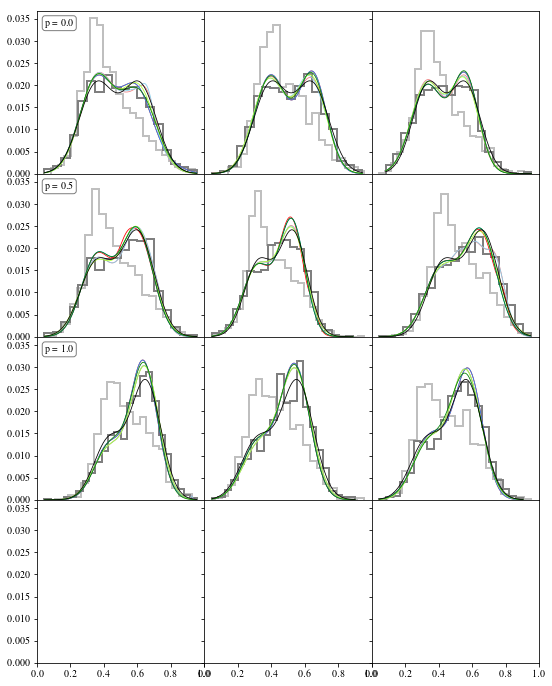

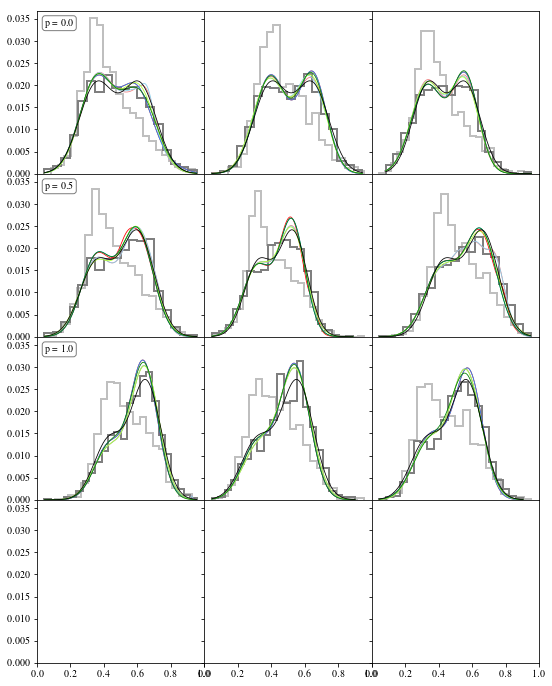

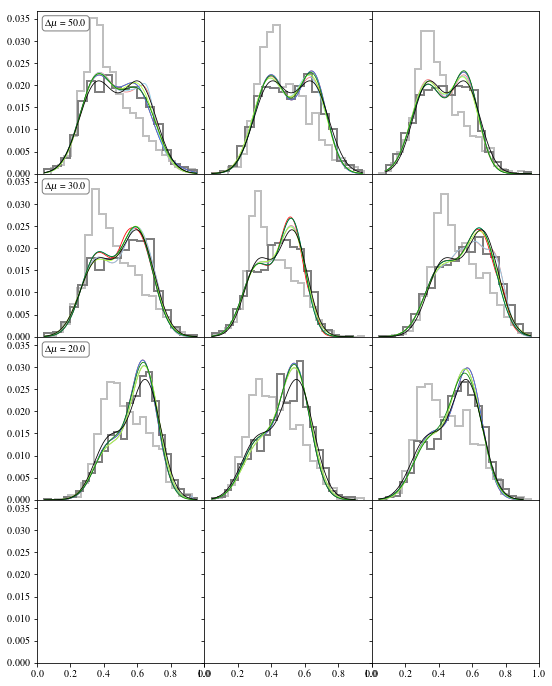

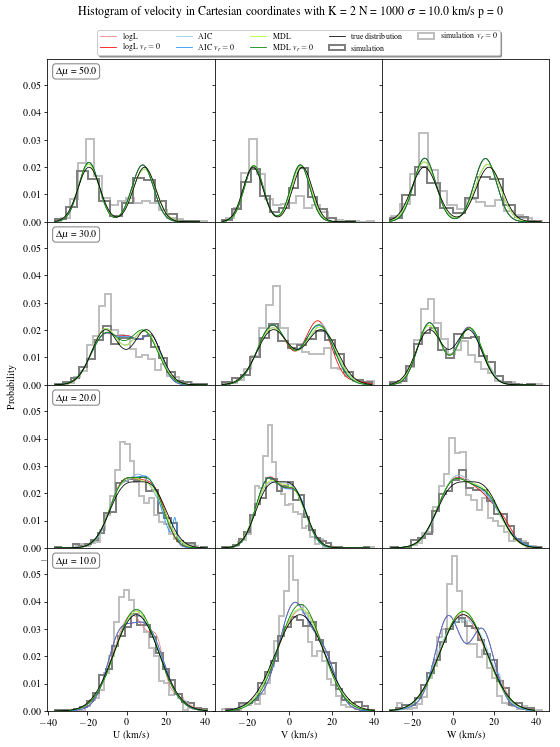

args: () kwargs: {'K': 2, 'N': 1000, 'sigma': 10.0, 'p': 0}


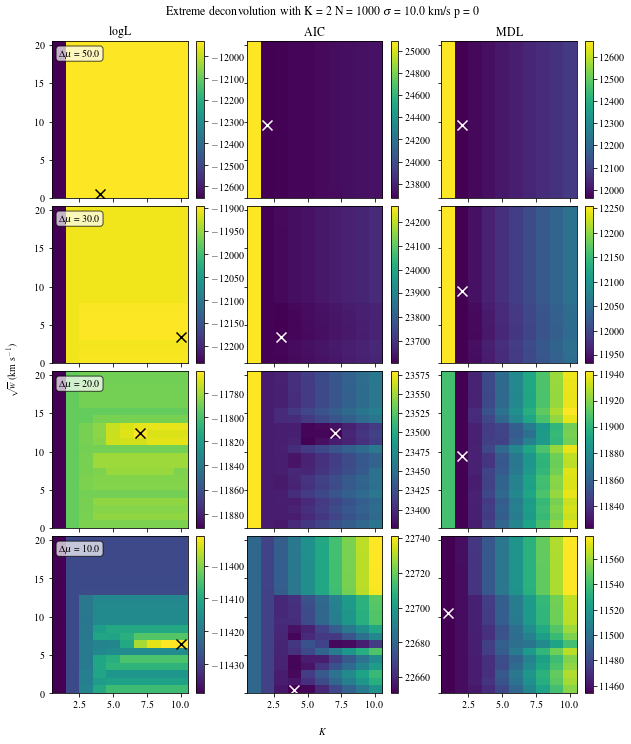

args: () kwargs: {'K': 2, 'N': 1000, 'sigma': 10.0, 'p': 0}


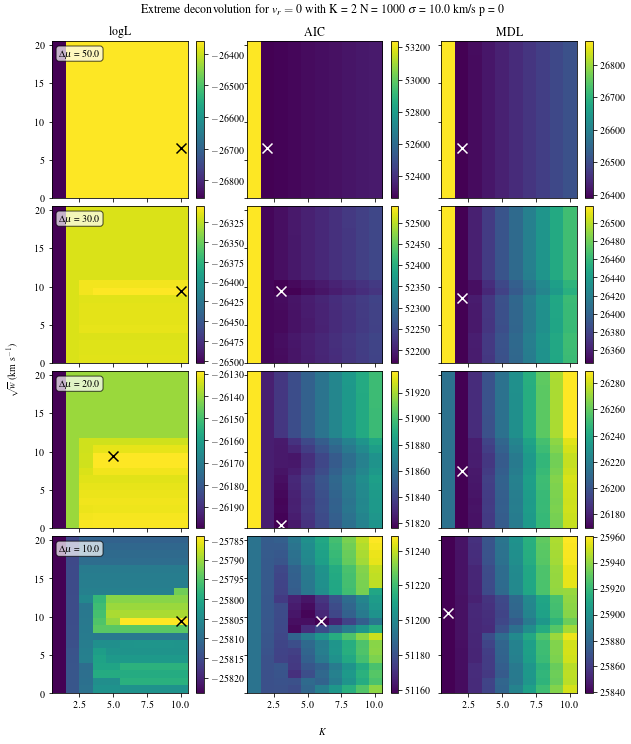

Vary amps..
p 0
[0.5 0.5] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW
Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
p 1
[0.41421356 0.58578644] [[ 0.  0.  0.]
 [25. 25. 25.]] [[[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]

 [[100.   0.   0.]
  [  0. 100.   0.]
  [  0.   0. 100.]]]
Transformation to astrometric observables..
Simulate measured values..
Projection..
Transforming to radians for..  ra
Transforming to radians for..  ra
Transforming to radians for..  dec
Transforming to radians for..  dec
w
pqr
R
C
Q
S
UVW
w
pqr
R
C
Q
S
UVW
Perform XD..
1
2
3
4
5
6
7
8
9
10
1
2
3
4
5
6
7
8
9
10
p 2
[0.33333333 0.6666

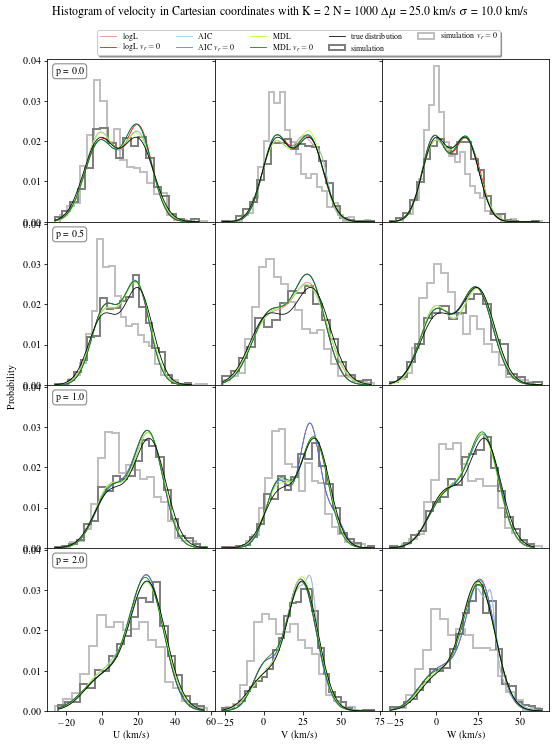

args: () kwargs: {'K': 2, 'N': 1000, 'meanstep': 25.0, 'sigma': 10.0}


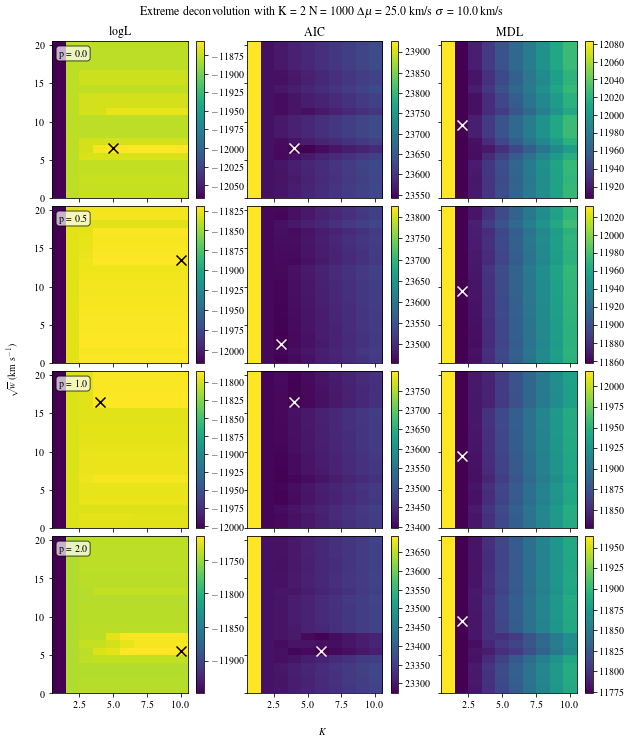

args: () kwargs: {'K': 2, 'N': 1000, 'meanstep': 25.0, 'sigma': 10.0}


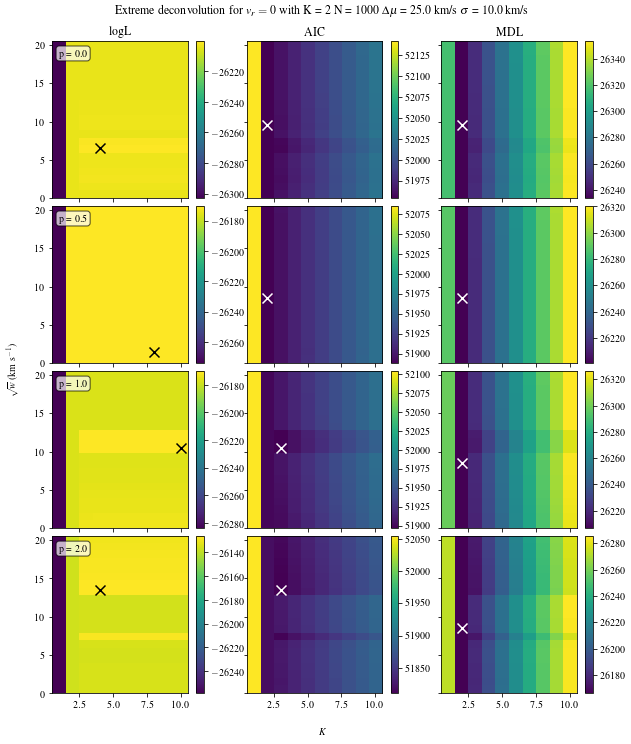

In [18]:
meanstepvary = [50., 30., 20., 10.] #km/s
pvary = [0., .5, 1., 2.] #relation between amplitudes of components

def initialize_vars():
    global initamps, initmeans, initcovs, varrarr, logLarr, AICarr, MDLarr, bestKarr, bestwarr, a_testarr, m_testarr, c_testarr,\
        varrarr_vr0, logLarr_vr0, AICarr_vr0, MDLarr_vr0, bestKarr_vr0, bestwarr_vr0, a_testarr_vr0, m_testarr_vr0, c_testarr_vr0
    initamps = np.zeros((len(meanstepvary),K,))
    initmeans = np.zeros((len(meanstepvary),K,3))
    initcovs = np.zeros((len(meanstepvary),K,3,3))
    varrarr = np.zeros((len(meanstepvary),N,3))
    logLarr = np.zeros((len(meanstepvary),len(Krange),len(wrange)))
    AICarr = np.zeros((len(meanstepvary),len(Krange),len(wrange)))
    MDLarr = np.zeros((len(meanstepvary),len(Krange),len(wrange)))
    bestKarr = [0,]*len(meanstepvary)
    bestwarr = [0,]*len(meanstepvary)
    a_testarr = [0,]*len(meanstepvary)
    m_testarr = [0,]*len(meanstepvary)
    c_testarr = [0,]*len(meanstepvary)
    varrarr_vr0 = np.zeros((len(meanstepvary),N,3))
    logLarr_vr0 = np.zeros((len(meanstepvary),len(Krange),len(wrange)))
    AICarr_vr0 = np.zeros((len(meanstepvary),len(Krange),len(wrange)))
    MDLarr_vr0 = np.zeros((len(meanstepvary),len(Krange),len(wrange)))
    bestKarr_vr0 = [0,]*len(meanstepvary)
    bestwarr_vr0 = [0,]*len(meanstepvary)
    a_testarr_vr0 = [0,]*len(meanstepvary)
    m_testarr_vr0 = [0,]*len(meanstepvary)
    c_testarr_vr0 = [0,]*len(meanstepvary)

initialize_vars()
print("Vary means..")
for i in range(len(meanstepvary)):
    print("meanstep", i)
    varrarr[i], varrarr_vr0[i], initamps[i], initmeans[i], initcovs[i],\
    logLarr[i], AICarr[i], MDLarr[i], a_testarr[i], m_testarr[i], c_testarr[i], bestKarr[i], bestwarr[i],\
    logLarr_vr0[i], AICarr_vr0[i], MDLarr_vr0[i], a_testarr_vr0[i], m_testarr_vr0[i], c_testarr_vr0[i],\
    bestKarr_vr0[i], bestwarr_vr0[i] = simulation(meanstepvary[i], 10., 0.)
plot_hist_uvw('$\Delta\mu$', meanstepvary, initamps, initmeans, initcovs, a_testarr, m_testarr, c_testarr, varrarr, a_testarr_vr0, m_testarr_vr0, c_testarr_vr0, varrarr_vr0, K=2, N=1000, sigma=10., p=0)
plot_XD_w_K('$\Delta\mu$', meanstepvary, logLarr, AICarr, MDLarr, bestKarr, bestwarr, False, K=2, N=1000, sigma=10., p=0)
plot_XD_w_K('$\Delta\mu$', meanstepvary, logLarr_vr0, AICarr_vr0, MDLarr_vr0, bestKarr_vr0, bestwarr_vr0, True, K=2, N=1000, sigma=10., p=0)

initialize_vars()
print("Vary amps..")
for i in range(len(pvary)):
    print("p", i)
    varrarr[i], varrarr_vr0[i], initamps[i], initmeans[i], initcovs[i],\
    logLarr[i], AICarr[i], MDLarr[i], a_testarr[i], m_testarr[i], c_testarr[i], bestKarr[i], bestwarr[i],\
    logLarr_vr0[i], AICarr_vr0[i], MDLarr_vr0[i], a_testarr_vr0[i], m_testarr_vr0[i], c_testarr_vr0[i],\
    bestKarr_vr0[i], bestwarr_vr0[i] = simulation(25., 10., pvary[i])
plot_hist_uvw('p', pvary, initamps, initmeans, initcovs, a_testarr, m_testarr, c_testarr, varrarr, a_testarr_vr0, m_testarr_vr0, c_testarr_vr0, varrarr_vr0, K=2, N=1000, meanstep=25., sigma=10.)
plot_XD_w_K('p', pvary, logLarr, AICarr, MDLarr, bestKarr, bestwarr, False, K=2, N=1000, meanstep=25., sigma=10.)
plot_XD_w_K('p', pvary, logLarr_vr0, AICarr_vr0, MDLarr_vr0, bestKarr_vr0, bestwarr_vr0, True, K=2, N=1000, meanstep=25., sigma=10.)

In [17]:
plot_hist_uvw('$\Delta\mu$', meanstepvary, initamps, initmeans, initcovs, a_testarr, m_testarr, c_testarr, varrarr, a_testarr_vr0, m_testarr_vr0, c_testarr_vr0, varrarr_vr0, K=2, N=1000, sigma=10., p=0)
plot_XD_w_K('$\Delta\mu$', meanstepvary, logLarr, AICarr, MDLarr, bestKarr, bestwarr, False, K=2, N=1000, sigma=10., p=0)
plot_XD_w_K('$\Delta\mu$', meanstepvary, logLarr_vr0, AICarr_vr0, MDLarr_vr0, bestKarr_vr0, bestwarr_vr0, True, K=2, N=1000, sigma=10., p=0)


TypeError: 'int' object is not subscriptable

In [ ]:
fig, ax = plt.subplots(1,3, sharey=True, figsize=(9,3))
velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
for v in range(len(velocities)):
    ax[v].hist(varr_vrad0[:,v], bins='auto', normed=True, facecolor='grey', histtype='stepfilled', alpha=0.3, label='varr')
    ax[v].hist(uvw_gal[:,v], bins='auto', normed=True, facecolor='black', histtype='stepfilled', alpha=0.5, label='uvwgal')
    ax[v].set_xlabel(velocities[v] + unit)
    ax[v].legend(loc='upper right', prop={'size': 6})
plt.show()

In [ ]:
plot_hist_uvw(initamps[K-1], initmeans[K-1], initcovs[K-1], amps_test, means_test, covs_test, varr, amps_test_vrad0, means_test_vrad0, covs_test_vrad0, varr_vrad0, K, N, meanstep, sigma, p, q)

In [ ]:
gfc.gplot.plot_XD_w_K(logL, AIC, MDL, bestK, bestw, False, Kmin, Kmax, wmin, wmax, K, N, meanstep, sigma, p, q)
gfc.gplot.plot_XD_w_K(logL_vrad0, AIC_vrad0, MDL_vrad0, bestK_vrad0, bestw_vrad0, True, Kmin, Kmax, wmin, wmax, K, N, meanstep, sigma, p, q)

In [ ]:
def KnownGroups(ax): #before: text
    ax.text(60, -90, "Arcturus")
    ax.plot([8, 57.5], [-105, -90], c='k', lw=2)
    ax.text(-80, -110, "Halo")
    ax.text(50, 40, "Sirius/UMa")
    ax.plot([49, 5], [40, 5], c='k', lw=2)
    ax.text(-100, 45, "Coma Berenices")
    ax.plot([-70, -10], [42, -5], c='k', lw=2)
    ax.text(-120, 34, "NGC 1901")
    ax.plot([-100, -25], [31, -12], c='k', lw=2)
    ax.text(-120, 0, "Hyades")
    ax.plot([-110, -45], [-3, -17], c='k', lw=2)
    ax.text(90, -50, "Pleiades")
    ax.plot([87, -15], [-45, -20], c='k', lw=2)
    ax.text(-125, -42, "Hercules")
    ax.plot([-93.5, -28], [-40, -42], c='k', lw=2)

def contourplot(array, ax, bins):
    for i in range(2):
        for j in range(2):
            if j != i + 1:
                H, xedges, yedges = np.histogram2d(array[:,j], array[:,i+1], bins)
                cs = ax[i+j].contourf(xedges[:-1], yedges[:-1], H.T, bins, cmap = 'binary')

def set_axes_3velocities(ax):  
    velocities = ('U', 'V', 'W') ; unit = ' (km/s)'
    xpos = ('top', 'bottom') ; ypos = ('left', 'right')
    for i in range(2):
        for j in range(2):
            if j != i + 1:
                ax[i+j].set_xlim(-130,120) ; ax[i+j].set_ylim(-70,70)
                ax[i+j].set_xlabel(velocities[j] + unit) ; ax[i+j].set_ylabel(velocities[i+1] + unit)
                ax[i+j].xaxis.set_label_position(xpos[i]) ; ax[i+j].yaxis.set_label_position(ypos[j])
    ax[0].xaxis.tick_top()
    ax[0].set_xticks((-100, -50, 0, 50, 100))
    ax[0].set_yticks((-100, -50, 0, 50))
    ax[0].set_ylim(-120,60)
    ax[2].yaxis.tick_right()

def plot_Gaussian_comps(amps, means, covs, t_uvw, total=False, *args):
    saveto = '/disks/strw9/vanweenen/mrp1/results/'
    filename = '/PDF'
    if total:
        filename += '_total'
        title = "Velocity distribution"
        ext = ((-140,140),(-130,130),(-72,72))
        PDFs = map(gfc.pdf.multivariate, means, covs, amps)
        evalxyz = gfc.pdf.eval_total_PDF(PDFs, [ext[0], ext[1], ext[2]])
        evaltot = (evalxyz.sum(2), evalxyz.sum(1), evalxyz.sum(0))
        levels = np.logspace(-6.,-2.7,10)
    else:
        line = ("xy", "xz", "yz") 
        title = "Gaussian components of velocity distribution"
    title, filename = gfc.gplot.title_filename(title, filename, *args)
    fig = plt.figure(figsize=(8,8))
    plt.suptitle(title)
    ax = [plt.subplot(2,1,1), plt.subplot(2,2,3), plt.subplot(2,2,4)]
    if total:
        for i in range(2):
            for j in range(2):
                if j != i +1:
                    ax[i+j].contour(evaltot[i+j], extent = [ext[j][0], ext[j][1], ext[i+1][0], ext[i+1][1]], cmap = plt.cm.viridis, levels=levels)
    else:
        for i in range (3):
            for a, m, c in zip(amps, means, covs):
                gfc.gplot.draw_PDF_ellipse(ax[i], a, m, c, line[i], edgecolor="0.4")
    contourplot(t_uvw, ax, 10)
    set_axes_3velocities(ax)    
    KnownGroups(ax[0])
    fig.savefig(saveto + filename)
    plt.show()

plot_Gaussian_comps(amps_test[0], means_test[0], covs_test[0], uvwarr_icrs, False)
plot_Gaussian_comps(amps_test[0], means_test[0], covs_test[0], uvwarr_icrs, True)

In [ ]:
pdfs_XD = map(gfc.pdf.multivariate, means_test[0], covs_test[0], amps_test[0])
for i,row in enumerate(t_astr_vrad0):
    vrad_predicted = gfc.radial_velocity_distribution(pdfs_XD, row["ra_rad"], row["dec_rad"], row["parallax"], row["pmra"], row["pmdec"], row["C"], t_astr['vrad_error'])
    print vrad_predicted